### This is the main notebook

First we we do some data cleaning and data exploration with plots.
Here we will use a neural network and a rf to predict the salaries. We will use different features for predicting it. 

In [113]:
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())  # To check MPS support

2.2.2
True


In [114]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


# Data Cleaning

In [115]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [116]:
print(df.columns)
print(type(df.Salary[0]))
print(type(df['Years of Experience'][0]))

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
<class 'numpy.float64'>
<class 'numpy.float64'>


In [117]:
# Combining the education level Bachelor's degree and Bachelor's
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

Text(0, 0.5, 'Salary')

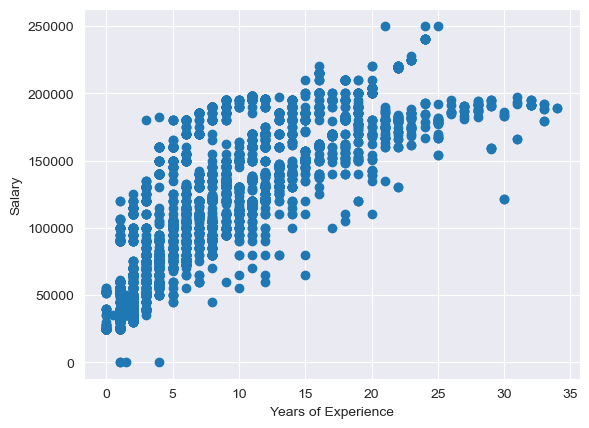

In [118]:
plt.scatter(df['Years of Experience'], df['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

/var/folders/v9/n514v4yd4hn8vqwrpj4cdt8c0000gn/T/ipykernel_16916/551786710.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

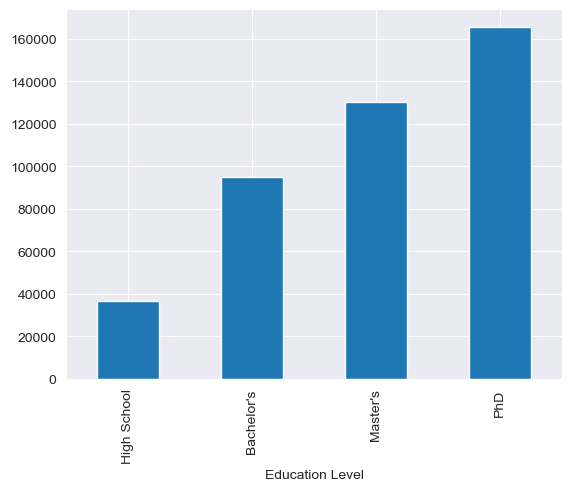

In [119]:
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [120]:
# Job Title with the most data
df['Job Title'].value_counts()

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Supply Chain Analyst            1
Name: count, Length: 193, dtype: int64

In [167]:
df.size

27168

In [121]:
# Remove Jobs with less than 10 data points
df = df.groupby('Job Title').filter(lambda x: len(x) > 100)
df['Job Title'].value_counts()

Job Title
Software Engineer            518
Data Scientist               453
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          309
Marketing Manager            255
Senior Software Engineer     244
Back end Developer           244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Name: count, dtype: int64

# Define Model

In [154]:
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [148]:
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Single-layer regression

    def forward(self, x):
        return self.fc(x)


# Prepare data

In [149]:
import joblib
from torch.utils.data import TensorDataset
# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df['Education Level'] = df['Education Level'].map(lambda x: education_mapping.get(x, x)).copy()

df = df[df['Gender'] != 'Other']
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(lambda x: gender_mapping.get(x, x)).copy()

df = df.dropna()

train, test = train_test_split(df, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

target_column = "Salary"
sensitive_feature = ['Age', 'Gender']
features = train.columns.difference([target_column])

scaler = StandardScaler()
train[['Years of Experience', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Age']])
val[['Years of Experience', 'Age']] = scaler.transform(val[['Years of Experience', 'Age']])
test[['Years of Experience', 'Age']] = scaler.transform(test[['Years of Experience', 'Age']])

# Create a separate scaler for 'Salary'
salary_scaler = StandardScaler()

# Fit and transform 'Salary' in train, transform in val and test
train['Salary'] = salary_scaler.fit_transform(train[['Salary']])
val['Salary'] = salary_scaler.transform(val[['Salary']])
test['Salary'] = salary_scaler.transform(test[['Salary']])


joblib.dump(scaler, "scaler_preds")

encoder = LabelEncoder()
train['Job Title'] = encoder.fit_transform(train['Job Title'])
val['Job Title'] = encoder.transform(val['Job Title'])
test['Job Title'] = encoder.transform(test['Job Title'])

X_train = pd.DataFrame((train),columns = features)
y_train = pd.DataFrame((train),columns = [target_column])
# X_train = torch.tensor(train[features].values, dtype=torch.float32)
# y_train = torch.tensor(train[target_column].values, dtype=torch.float32).view(-1, 1)
X_val = pd.DataFrame((val),columns = features)
y_val = pd.DataFrame((val),columns = [target_column])
# X_val = torch.tensor(val[features].values, dtype=torch.float32)
# y_val = torch.tensor(val[target_column].values, dtype=torch.float32).view(-1, 1)
X_test = pd.DataFrame((test),columns = features)
y_test = pd.DataFrame((test),columns = [target_column])
# X_test = torch.tensor(test[features].values, dtype=torch.float32)
# y_test = torch.tensor(test[target_column].values, dtype=torch.float32).view(-1, 1)

# Convert features to float32 tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Convert targets to float32 tensors for regression
y_train_tensor = torch.tensor(y_train.squeeze().values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.squeeze().values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.squeeze().values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [150]:
print(features)

Index(['Age', 'Education Level', 'Gender', 'Job Title', 'Years of Experience'], dtype='object')


In [151]:
X_train_tensor

tensor([[-0.6115,  1.0000,  0.0000, 16.0000, -0.3790],
        [ 0.0341,  1.0000,  1.0000,  6.0000,  0.1119],
        [ 1.5835,  2.0000,  0.0000, 14.0000,  1.9122],
        ...,
        [ 0.6797,  2.0000,  1.0000, 10.0000,  0.2756],
        [-0.9988,  2.0000,  1.0000,  4.0000, -1.0336],
        [-0.9988,  1.0000,  0.0000, 15.0000, -1.0336]])

In [152]:
import numpy as np

def evaluate_model_on_original_scale(model, data_loader, salary_scaler):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())

    # Convert predictions and targets back to the original scale
    predictions_original_scale = salary_scaler.inverse_transform(predictions)
    targets_original_scale = salary_scaler.inverse_transform(targets)

    # Calculate the average error (Mean Absolute Error)
    average_error = np.mean(np.abs(predictions_original_scale - targets_original_scale))

    return predictions_original_scale, targets_original_scale, average_error


# Training For Data Scientist Job not important for prediction

In [141]:
import torch.optim as optim
from opacus import PrivacyEngine
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SalaryPredictor(input_size=len(features))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# enter PrivacyEngine
privacy_engine = PrivacyEngine()
model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=1.1,
    max_grad_norm=1.0,
)

for epoch in range(501):  # Example: 100 epochs
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluate on validation set at each epoch
    if epoch % 100 == 0:  # Example: Print every 10 epochs
        preds, targets, avg_error = evaluate_model_on_original_scale(model, val_loader, salary_scaler)
        print(f"Epoch {epoch + 1}, Validation Loss: {loss.item():.4f}")
        print(f"Average Error: {avg_error:.2f}")


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward c

Epoch 1, Validation Loss: 0.6482
Average Error: 35827.94
Epoch 101, Validation Loss: 0.2066
Average Error: 16674.77


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 201, Validation Loss: 0.0248
Average Error: 14298.12


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 301, Validation Loss: 0.2207
Average Error: 14659.87


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 401, Validation Loss: 0.1195
Average Error: 15156.51


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 501, Validation Loss: 0.0463
Average Error: 13519.24


In [144]:
# Training Without Privacy
model_no_privacy = SalaryPredictor(input_size=len(features))
optimizer_no_privacy = optim.Adam(model_no_privacy.parameters(), lr=1e-3)
criterion = nn.MSELoss()


# Training Loop Without Privacy
for epoch in range(501):  # Example: 100 epochs
    model_no_privacy.train()
    for X_batch, y_batch in train_loader:
        optimizer_no_privacy.zero_grad()
        predictions = model_no_privacy(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer_no_privacy.step()

    # Evaluate on validation set at each epoch
    if epoch % 100 == 0:  # Example: Print every 10 epochs
        preds, targets, avg_error = evaluate_model_on_original_scale(model_no_privacy, val_loader, salary_scaler)
        print(f"Epoch {epoch + 1}, Validation Loss: {loss.item():.4f}")
        print(f"Average Error: {avg_error:.2f}")


Epoch 1, Validation Loss: 0.2842
Average Error: 23257.60
Epoch 101, Validation Loss: 0.0738
Average Error: 11617.98
Epoch 201, Validation Loss: 0.0445
Average Error: 9346.79
Epoch 301, Validation Loss: 0.0082
Average Error: 8589.14
Epoch 401, Validation Loss: 0.0555
Average Error: 8278.32
Epoch 501, Validation Loss: 0.0038
Average Error: 7201.15


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None
/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated a

Training with Differential Privacy...
Epoch 1, Avg Error (DP): 43664.61
Epoch 11, Avg Error (DP): 23800.79


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 21, Avg Error (DP): 22191.39


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 31, Avg Error (DP): 21736.00


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 41, Avg Error (DP): 21307.75


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 51, Avg Error (DP): 21177.56


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 61, Avg Error (DP): 19961.25


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 71, Avg Error (DP): 20266.29


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 81, Avg Error (DP): 19845.05


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 91, Avg Error (DP): 19331.32


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 101, Avg Error (DP): 19614.99


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 111, Avg Error (DP): 18477.61


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 121, Avg Error (DP): 18675.17


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 131, Avg Error (DP): 18585.80


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 141, Avg Error (DP): 18232.83


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 151, Avg Error (DP): 18475.37


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 161, Avg Error (DP): 18371.93


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 171, Avg Error (DP): 17796.92


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 181, Avg Error (DP): 19125.22


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 191, Avg Error (DP): 17685.89


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 201, Avg Error (DP): 18408.53


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 211, Avg Error (DP): 18168.79


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 221, Avg Error (DP): 17658.97


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 231, Avg Error (DP): 17368.63


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 241, Avg Error (DP): 16926.23


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 251, Avg Error (DP): 17189.70


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 261, Avg Error (DP): 17227.23


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 271, Avg Error (DP): 17916.39


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 281, Avg Error (DP): 18471.24


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 291, Avg Error (DP): 18403.83


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  hook(module, grad_output) -> tuple[Tensor] or None


Epoch 301, Avg Error (DP): 18059.19
Training without Differential Privacy...
Epoch 1, Avg Error (No DP): 22081.88
Epoch 11, Avg Error (No DP): 16374.58
Epoch 21, Avg Error (No DP): 14904.70
Epoch 31, Avg Error (No DP): 13537.07
Epoch 41, Avg Error (No DP): 13548.78
Epoch 51, Avg Error (No DP): 12212.96
Epoch 61, Avg Error (No DP): 11487.94
Epoch 71, Avg Error (No DP): 11172.37
Epoch 81, Avg Error (No DP): 11731.29
Epoch 91, Avg Error (No DP): 10846.50
Epoch 101, Avg Error (No DP): 10802.40
Epoch 111, Avg Error (No DP): 10792.68
Epoch 121, Avg Error (No DP): 10486.46
Epoch 131, Avg Error (No DP): 9643.45
Epoch 141, Avg Error (No DP): 9744.81
Epoch 151, Avg Error (No DP): 9815.55
Epoch 161, Avg Error (No DP): 9370.68
Epoch 171, Avg Error (No DP): 8949.13
Epoch 181, Avg Error (No DP): 8678.64
Epoch 191, Avg Error (No DP): 8422.21
Epoch 201, Avg Error (No DP): 8679.71
Epoch 211, Avg Error (No DP): 8346.47
Epoch 221, Avg Error (No DP): 8196.84
Epoch 231, Avg Error (No DP): 9026.63
Epoch 241

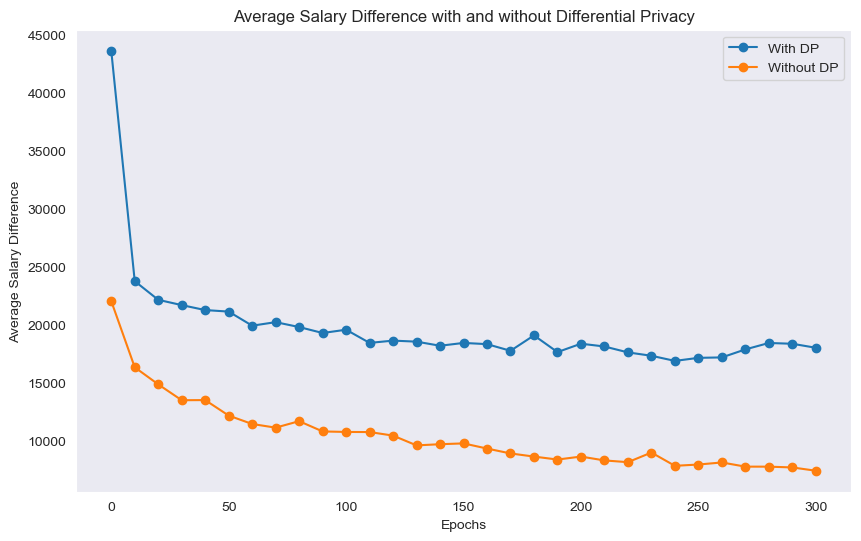

Final evaluation on test set...
Average Test Error (With DP): 17643.52
Average Test Error (Without DP): 7480.72


In [178]:
# Initialize lists to store average errors
avg_errors_with_dp = []
avg_errors_without_dp = []

# Training with Differential Privacy
model = SalaryPredictor(input_size=len(features))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Enter PrivacyEngine
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=3,
    max_grad_norm=1.0,
)

print("Training with Differential Privacy...")
for epoch in range(301):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:  # Record errors every 100 epochs
        _, _, avg_error = evaluate_model_on_original_scale(model, val_loader, salary_scaler)
        avg_errors_with_dp.append(avg_error)
        print(f"Epoch {epoch + 1}, Avg Error (DP): {avg_error:.2f}")

# Training Without Differential Privacy
model_no_privacy = SalaryPredictor(input_size=len(features))
optimizer_no_privacy = optim.Adam(model_no_privacy.parameters(), lr=1e-3)

print("Training without Differential Privacy...")
for epoch in range(301):
    model_no_privacy.train()
    for X_batch, y_batch in train_loader:
        optimizer_no_privacy.zero_grad()
        predictions = model_no_privacy(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer_no_privacy.step()

    if epoch % 10 == 0:  # Record errors every 100 epochs
        _, _, avg_error = evaluate_model_on_original_scale(model_no_privacy, val_loader, salary_scaler)
        avg_errors_without_dp.append(avg_error)
        print(f"Epoch {epoch + 1}, Avg Error (No DP): {avg_error:.2f}")

# Plotting the Results
epochs = range(0, 301, 10)

plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_errors_with_dp, label="With DP", marker="o")
plt.plot(epochs, avg_errors_without_dp, label="Without DP", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average Salary Difference")
plt.title("Average Salary Difference with and without Differential Privacy")
plt.legend()
plt.grid()
plt.show()

# Evaluate Final Models on Test Set
print("Final evaluation on test set...")

# Evaluate model with DP
_, _, avg_error_dp_test = evaluate_model_on_original_scale(model, test_loader, salary_scaler)
print(f"Average Test Error (With DP): {avg_error_dp_test:.2f}")

# Evaluate model without DP
_, _, avg_error_no_dp_test = evaluate_model_on_original_scale(model_no_privacy, test_loader, salary_scaler)
print(f"Average Test Error (Without DP): {avg_error_no_dp_test:.2f}")

In [179]:
delta = 1 / df.size
epsilon = privacy_engine.get_epsilon(delta)
print(f"ε = {epsilon:.2f} delta={delta}")

ε = 2.40 delta=3.680800942285041e-05


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Test loss 0.18

In [19]:
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,0,1,Software Engineer,5.0,90000.0
1,28.0,1,2,Data Analyst,3.0,65000.0
5,29.0,0,1,Marketing Analyst,2.0,55000.0
6,42.0,1,2,Product Manager,12.0,120000.0
8,26.0,1,1,Marketing Coordinator,1.0,45000.0
...,...,...,...,...,...,...
6682,28.0,0,3,Marketing Manager,4.0,55000.0
6690,42.0,0,1,Financial Manager,13.0,130000.0
6691,36.0,1,3,Marketing Manager,9.0,95000.0
6701,30.0,1,1,Financial Manager,4.0,55000.0


It's important to note that these values represent the increase in the model's error when the feature is permuted. A larger increase in error indicates that the feature is more important for the model's predictions

# Is Uni worth it?

In [23]:
#Other model
## The idea is to see if 4 years of experience is worth more than a Bachelor or 6 years more than a Master's or 10 years more than a PhD

#make fake data for seeing if uni is worth it


df_fake = pd.DataFrame([
    [27, "Male", "High School", "Software Engineer", 9, 1],
    [27, "Male", "Bachelor's", "Software Engineer",6 , 1],
    [27, "Male", "Master's", "Software Engineer", 4, 1],
    [27, "Male", "PhD", "Software Engineer", 2, 1]
], columns=["Age", "Gender", "Education Level", "Job Title", "Years of Experience", "Salary"])



# -----------NOT NECESSARY IF ALREADY DONE -------------
# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_fake['Education Level'] = df_fake['Education Level'].map(education_mapping).copy()

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_fake['Gender'] = df_fake['Gender'].map(gender_mapping).copy()


# Scale 'Years of Experience', 'Age', and 'Salary' for stability
scaler = joblib.load("C:\Master\ML_theory\Github\ml_project\Salary new dataset\scaler_only_se")
df_fake[['Years of Experience', "Salary", 'Age']] = scaler.transform(df_fake[['Years of Experience', "Salary", 'Age']])


X_train = torch.tensor(df_fake[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)

model_SE_gen_age.load_state_dict(torch.load("C:\Master\ML_theory\Github\ml_project\Salary new dataset\model_SE_gen_age.pth")) #load the model
model_SE_gen_age.eval()

with torch.no_grad():
    predictions = model_SE_gen_age(X_train)

print(predictions)

predictions_np = predictions.numpy()

dummy_array = np.zeros((len(predictions_np), 3))  # 3 columns for Years of Experience, Salary, Age
dummy_array[:, 0] = df_fake['Years of Experience']  # Scaled Years of Experience
dummy_array[:, 1] = predictions_np.flatten()  # Predictions (to be treated as Salary)
dummy_array[:, 2] = df_fake['Age']  # Scaled Age

# Inverse transform using the scaler
real_salaries = scaler.inverse_transform(dummy_array)[:, 1]  # Extract only the Salary column

# Print the real salaries
for i, salary in enumerate(real_salaries):
    print(f"Datapoint {i+1}: Predicted Salary = ${salary:.2f}")


tensor([[ 2.0894],
        [ 1.5285],
        [ 0.1004],
        [-1.3419]])
Datapoint 1: Predicted Salary = $211993.93
Datapoint 2: Predicted Salary = $185075.86
Datapoint 3: Predicted Salary = $116533.76
Datapoint 4: Predicted Salary = $47307.40
